# Goh Yu Jie's CA1 Classification Model (Factory machine)

#### Name: Goh Yu Jie

#### ID: 2415901

#### Class: DAAA/FT/1B/04

#### • How is your prediction task defined? And what is the meaning of the output variable? <br>
The prediction task is defined as a binary classification problem. This model has been provided with data about the properties of factory machines and whether the machine is faulty or works fine. This is to allow the model to train on such data, obtain new and unseen machine information to predict whether the machine is faulty or not. The output is 0 or 1 where 0 means that it is normal while 1 meaning that it is abnormal..

#### *  Did you process the features in any way?
1) Handle Missing/Unknown Values: Impute or remove unknown values.<br>
   
2) Convert Categorical Features: Encode the categorical feature(s) using one-hot or ordinal encoding.<br>

3) Transform Skewed Features: Apply transformations to reduce skewness, especially for features like Rotation Speed.<br>

4) Handle Outliers: Use capping, removal, or robust scaling on features with extreme outliers.<br>

5) Balance Target Variable: Use resampling techniques (e.g., SMOTE) or class weighting to address class imbalance.<br>

#### * How did you select which learning algorithms to use?
  Through understanding the target variable. If the target varibale is a binary such as thsi case where 1 is abnormal and 0 is normal, we should use classification models

#### * Did you try to tune the hyperparameters of the learning algorithm, and how?
  I tuned my hyperparameter using gridsearchcv method and used the 2 best/most commonly tuned parameters of my best performing model

#### *  How well does your system compare to a dummy baseline?
Feature  Importance<br>
* Torque (Nm)    0.315098

* Rotation_Speed_BoxCox    0.286804
    
* Tool Wear (min)    0.217778
  
* Ambient T (C)    0.097659
  
* Process T (C)    0.066141
  
* Quality_encoded    0.016520

#### *  Is it possible to say something about which features the model considers important? (Whether this is possible depends on the type of classifier you are using)
The Random Forest model provides feature importance scores, which indicate the contribution of each feature to the model's predictions.The higher the value, the more important it is

## Background:

This is a dataset collected from a manufacturing factory. The dataset contains various
information on different machines. From the perspective of quality control, the factory
wants to build a machine learning model to predict whether the machine is working
properly or fault

## Objectives:

Create a classification mdoel that predicts machine's health

##### Step 0. Data Preparation

In [16]:
# Importing the necessarty modules
import pandas as pd # Handles DataFrame
import matplotlib.pyplot as plt #Plot Graphs
import seaborn as sns # Plotting Graphs
sns.set_theme(palette='pastel')

import numpy as np

# import func that allows us to do test-split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit # Hyperparamter tuning + cross validation
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as IMBPipeline
from sklearn.linear_model import Ridge, Lasso

# Models
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC


# import func to perform model evaluation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,RocCurveDisplay
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, make_scorer, precision_score
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_predict,
    learning_curve,
    StratifiedKFold,
)

# Saving and Loading Models
import joblib # for saving sklearn models
import pickle # for saving pipelines or custom transformations

In [17]:
#Loading the data for Classification and analysis
df = pd.read_csv("factory_data.csv", dtype={
    "Quality": "category",               # Categorical feature
    "Ambient T (C)": float,              # Continuous feature
    "Process T (C)": float,              # Continuous feature
    "Rotation Speed (rpm)": float,       # Continuous feature
    "Torque (Nm)": float,                # Continuous feature
    "Tool Wear (min)": int,              # Discrete feature
    "Machine Status": int                # Target variable 
})
# df =  pd.read_csv("factory_data.csv")
df.head()  # Print the first few rows of dataset

,Unique ID,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
0,1,K12965,M,24.95,35.45,1551.0,42.8,0,0
1,2,Z62710,L,25.05,35.55,1408.0,46.3,3,0
2,3,T20224,L,24.95,35.35,1498.0,49.4,5,0
3,4,Z33024,L,25.05,35.45,1433.0,39.5,7,0
4,5,Z52839,L,25.05,35.55,1408.0,40.0,9,0


##  <span style="background-color: lightblue;">Step 1. Exploratory Data Analysis</span>

First and foremost, we start with Exploratory Data Analysis (EDA) which will provide a strong foundation in understanding the different features involved and how they will affect the machine's status.


This involves analysing the dataset's structure, distributions, relationships and potential issues.


We first have to gain a brief understanding of the 8 different machine's properties and our target variable "Machine status"


* <mark>Unique ID</mark>: (Numerical)<br>Helps track individual rows and the count of machines involved

* <mark>Product ID</mark>: (Categorical)<br>Allows for differentiation machines of all kinds

* <mark>Quality</mark>: (Categorical)<br>Refers to the specification level achieved by the product, H, L and M

* <mark>Ambient T(C)</mark>: (Numerical) <br>Refers to surrounding temperature in degrees Celsius

* <mark>Process T(C)</mark>: (Numerical)<br>Refers to tmeperature within machine during the manufacturing process

* <mark>Rotation Speed(rpm)</mark>: (Numerical)<br>Describes how fast the component of the machine is rotating

* <mark>Torque (Nm)</mark>: (Numerical)<br>Refers to the force that cause rotation in the machine

* <mark>Tool Wear (min)</mark>: (Numerical) <br>Amount of water on the tool, measured in minutes of usage

* <mark>Machine Status</mark>: (Binary)<br>Representation of the overall health of machine through its properties. Label indicates its conditiond, 0 being normal, 1 being abnormal 

####   <span style="background-color: lightblue;">Exploring DataSet</span>

Before we start, We have to create ca copy of the original dataset to prevent it from being mutated

In [33]:
df_copy = df.copy()

1.1 Descriptive informations

In [35]:
#Getting the rows and columns 
df_copy.shape

(20000, 9)

In [36]:
#Find ouut the number of missing values in each columns
df_copy.isna().sum()

Unique ID                  0
Product ID                 0
Quality                  991
Ambient T (C)              0
Process T (C)            400
Rotation Speed (rpm)    1188
Torque (Nm)                0
Tool Wear (min)            0
Machine Status             0
dtype: int64

In [37]:
#Finding the missing values in each column (percentages)
df_copy.isna().sum()/df_copy.count()

Unique ID               0.000000
Product ID              0.000000
Quality                 0.052133
Ambient T (C)           0.000000
Process T (C)           0.020408
Rotation Speed (rpm)    0.063151
Torque (Nm)             0.000000
Tool Wear (min)         0.000000
Machine Status          0.000000
dtype: float64

In [38]:
#Get data types and non-null counts for each column
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Unique ID             20000 non-null  int64   
 1   Product ID            20000 non-null  object  
 2   Quality               19009 non-null  category
 3   Ambient T (C)         20000 non-null  float64 
 4   Process T (C)         19600 non-null  float64 
 5   Rotation Speed (rpm)  18812 non-null  float64 
 6   Torque (Nm)           20000 non-null  float64 
 7   Tool Wear (min)       20000 non-null  int32   
 8   Machine Status        20000 non-null  int32   
dtypes: category(1), float64(4), int32(2), int64(1), object(1)
memory usage: 1.1+ MB


In [39]:
#Get a statistical summary for numerical columns
df_copy.describe()

,Unique ID,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
count,20000.000000,20000.000000,19600.000000,18812.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,26.904930,36.904291,1538.795397,39.986910,107.951000,0.033900
std,5773.647028,2.000834,1.483647,178.674963,9.968684,63.652555,0.180976
min,1.000000,22.150000,32.550000,1168.000000,3.800000,0.000000,0.000000
25%,5000.750000,25.250000,35.750000,1423.000000,33.200000,53.000000,0.000000
50%,10000.500000,26.950000,36.950000,1503.000000,40.100000,108.000000,0.000000
75%,15000.250000,28.450000,37.950000,1613.000000,46.800000,162.000000,0.000000
max,20000.000000,31.450000,40.750000,2886.000000,76.600000,253.000000,1.000000


In [40]:
#Check for duplicates
df.duplicated().sum()

0

Based on the imformation collected above, we conclude that there are a total of 20 000 rows and 9 columns. The columns include 2 Meta variables, 6 feature variables and 1 target variable

We can also tell that of all the Data Types, we have one categorical data we have to handle (later on during Data prepocessing)and that is our Quality column which 3 types of categories <mark>(Small, Medium ,Large)</mark> .There are a total of 3 columns filled with missing values which has to be handled. This columns include quality <mark>(5.21%)</mark> , Process <mark>(2.04%)</mark> and Rotation Speed <mark>(6.32%)</mark>.

##  <span style="background-color: lightblue;">Step 1.2: Data Informarion</span>

The above steps mainly focused on analysing our Meta and Feature variables. Let's now explore and better understand our target variable, Machine Status

In [45]:
# Locating distinct values in Target Variables 
df_copy["Machine Status"].unique()

array([0, 1])

  We note that our target variable is truly made of binary values 1 or 0 which we have assumed <br>
- 0 => Normal
- 1 => Abnormal

In [47]:
# Obtain count of each class to access distribution
df_copy['Machine Status'].value_counts()

Machine Status
0    19322
1      678
Name: count, dtype: int64

In [48]:
# Viewing the count of each class in percentages
df['Machine Status'].value_counts(normalize=True)


Machine Status
0    0.9661
1    0.0339
Name: proportion, dtype: float64

Let's start accessing our distribution of "Machine Status" in our dataset including making a simple class pie chart and a bar graph

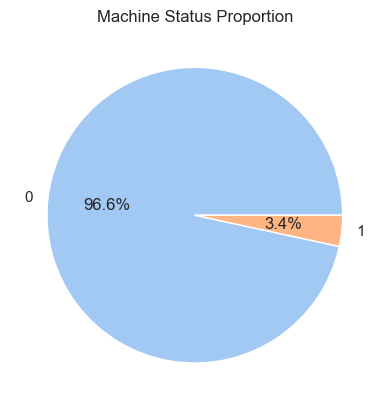

In [50]:
# My pie chart
import matplotlib.pyplot as plt
labels = df_copy['Machine Status'].value_counts().index
sizes = df_copy['Machine Status'].value_counts().values
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Machine Status Proportion')
plt.show()

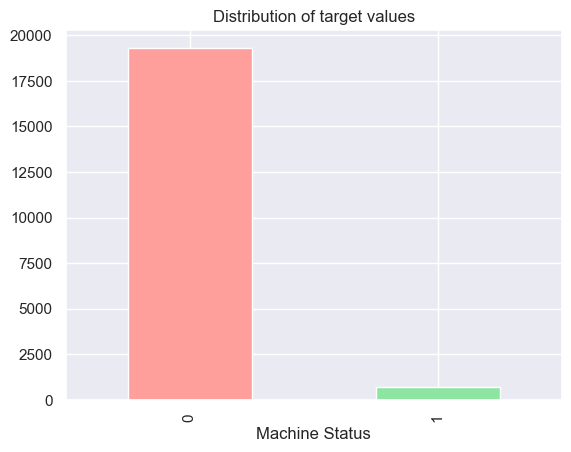

In [51]:
# My bar graph
bar_values = df_copy['Machine Status'].value_counts()
bar_values.plot(kind="bar", title="Distribution of target values", color = ['r', 'g'])
plt.show()

From the 2 plots created, we can draw conclusions that the distribution of our target values are imbalanced. We can tell that the machine status of "normal" is 96.6% which is about 28 times more than the machine status of "Abnormal" of 3.4%

####  <span style="background-color: lightblue;">1.21 Data Visualisation</spam>

We now move on to visualising our data using multiple histograms, each histogram allows for the comparison of the distribution of varibales across different classes.

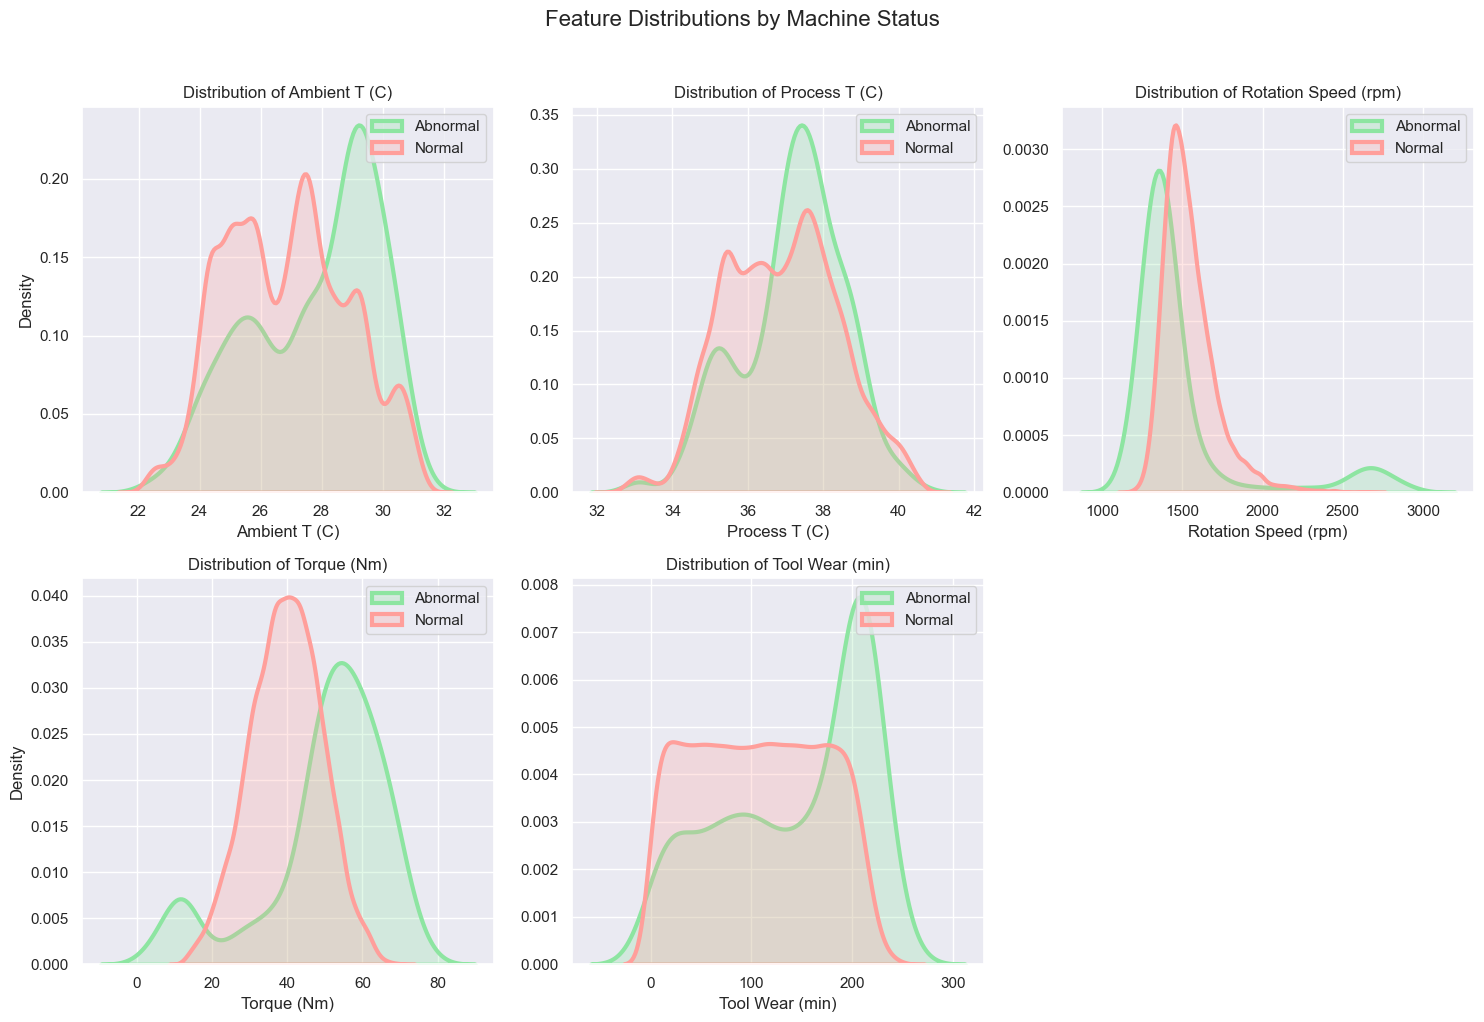

In [55]:
#Plotting my histogram
def plot_hist(features):
    num_features = len(features)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows and 3 columns

    for i, feature in enumerate(features):
        row, col = divmod(i, 3)

        sns.kdeplot(
            df[df["Machine Status"] == 1][feature], lw=3, color="g", ax=axes[row, col], label='Abnormal', fill=True
        )
        sns.kdeplot(
            df[df["Machine Status"] == 0][feature], lw=3, color="r", ax=axes[row, col], label='Normal', fill=True
        )

        axes[row, col].legend()
        axes[row, col].set_title(f"Distribution of {feature}")
        axes[row, col].set_xlabel(feature)

        # Label y-axis only for the first column
        if col == 0:
            axes[row, col].set_ylabel("Density")
        else:
            axes[row, col].set_ylabel("")

    # Hide any remaining empty subplot spaces (like the last one in a 2x3 layout for 5 plots)
    for j in range(num_features, 2 * 3):  # Total subplots in 2x3 grid is 6
        fig.delaxes(axes.flatten()[j])

    plt.suptitle("Feature Distributions by Machine Status", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

plot_hist(["Ambient T (C)", "Process T (C)", "Rotation Speed (rpm)", "Torque (Nm)", "Tool Wear (min)"])
#did not include "unique id" and "product id" because theuy are identifiers and we excluded "quality" because it is a categorical data

#### Summary for features' distrubution graphs:

* Ambient Temperature (T): <br> - There is a clear separation between normal and abnormal machine status distributions. Abnormal machines (green) tend to have a wider range of ambient temperatures, especially at higher temperatures, compared to normal machines (red), which have a more concentrated distribution. This could suggest that higher ambient temperatures might be correlated with machine abnormalities.

* Process Temperature (T): <br> - The process temperature for abnormal machines is also spread over a larger range than for normal machines, with abnormal readings extending towards both higher and lower temperatures. However, there is significant overlap, which might imply that process temperature alone may not be a strong predictor of machine status.

* Rotation Speed (rpm): <br> - The rotation speed distribution for abnormal machines is generally lower than that for normal machines, which has a peak in the 1500-2000 rpm range. This indicates that abnormal status might be associated with reduced rotation speeds, possibly pointing to an issue in the machine's performance.

* Torque (Nm): <br> - For normal machines, torque is distributed mostly around 30–50 Nm, while for abnormal machines, it spans a larger range, including lower values. Lower torque could be an indicator of potential issues in the machine, as abnormal machines have a broader torque distribution.

* Tool Wear (min): <br> - Abnormal machines show higher tool wear times, concentrated around the 200-300 minute range, while normal machines have tool wear mostly in the lower end of this range. This could imply that abnormal machine conditions may be linked to extended tool wear times, possibly due to excessive stress or usage.

All in all, these distribution plots suggests that Ambient Temperature, Rotation Speed, Torque and Tool Wear are likely influential factors in distinguishing between normal and abnormal machine statuses. But because of the huge overlapbetween normal and abnormal distributions, Process Temperature as a feature may need further analysis.

#### <span style="background-color: lightblue;"> We can also use a heatmap to find correlations between the different properties </span>

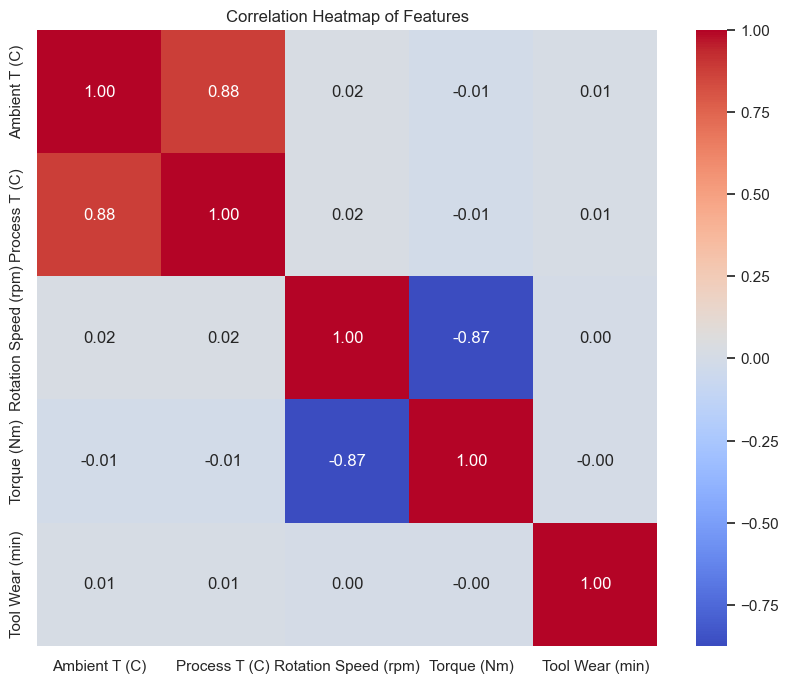

In [64]:
# Calculate the correlation matrix
correlation_matrix = df[["Ambient T (C)", "Process T (C)", "Rotation Speed (rpm)", "Torque (Nm)", "Tool Wear (min)"]].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()

#### Summary for correlations heatmap:

1) There is a high correlation betwwen Amient T(c) and Process T(c) where they have a correlation coefficient of 0.88 which indicates a strong positive relationship. As Ambient T(c) increases, Process T (c) will tend to increase

2. There is a strong negative correlation between Rotation Speed (rpm) and Torque (Nm) of a correlation coefficient of -0.87 which suggests that as Rotation speed (rpm) increases, Torque (Nm) will tend to decrease and vice versa

3. There is a low correlation among other feature pairs where the have low or near-zero correlation with one another. This implies that they capture different aspects of data and are likly to contribute unqiue information to the model

High correlation between features is primarily a concern for models that assume feature independence, such as linear regression or logistic regression. Tree-based models like Random Forests and Gradient Boosting are generally less affected by multicollinearity.


#### <span style="background-color: lightblue;"> Lets not forget about our categorical variable (quality) which we have yet to analyse its distributions </span>

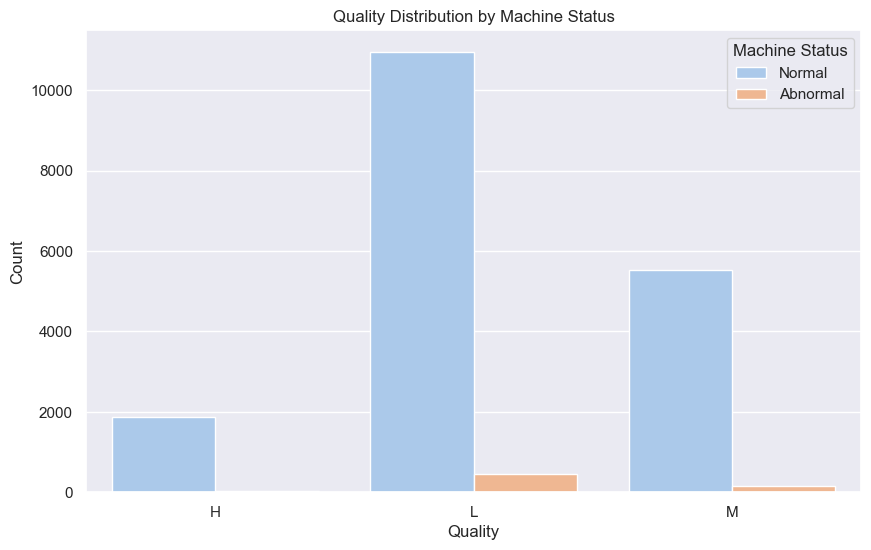

In [71]:
#Distribution of categorical variable
plt.figure(figsize=(10, 6))

# Create a count plot grouped by 'Machine Status'
sns.countplot(data=df, x='Quality', hue='Machine Status', palette='pastel')

# Add title and labels
plt.title('Quality Distribution by Machine Status')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.legend(title='Machine Status', labels=['Normal', 'Abnormal'])

# Show the plot
plt.show()


Out of the 3 types of quality, we can see that "L" has the largest normal and abnormal counts among the types, followed by "M" then "H" ."H" has the highest percentage normal count of 100% without any abnormal count. This might have created an imbalance within the feature since only a certain type has a mix of both normal and abnormal counts 

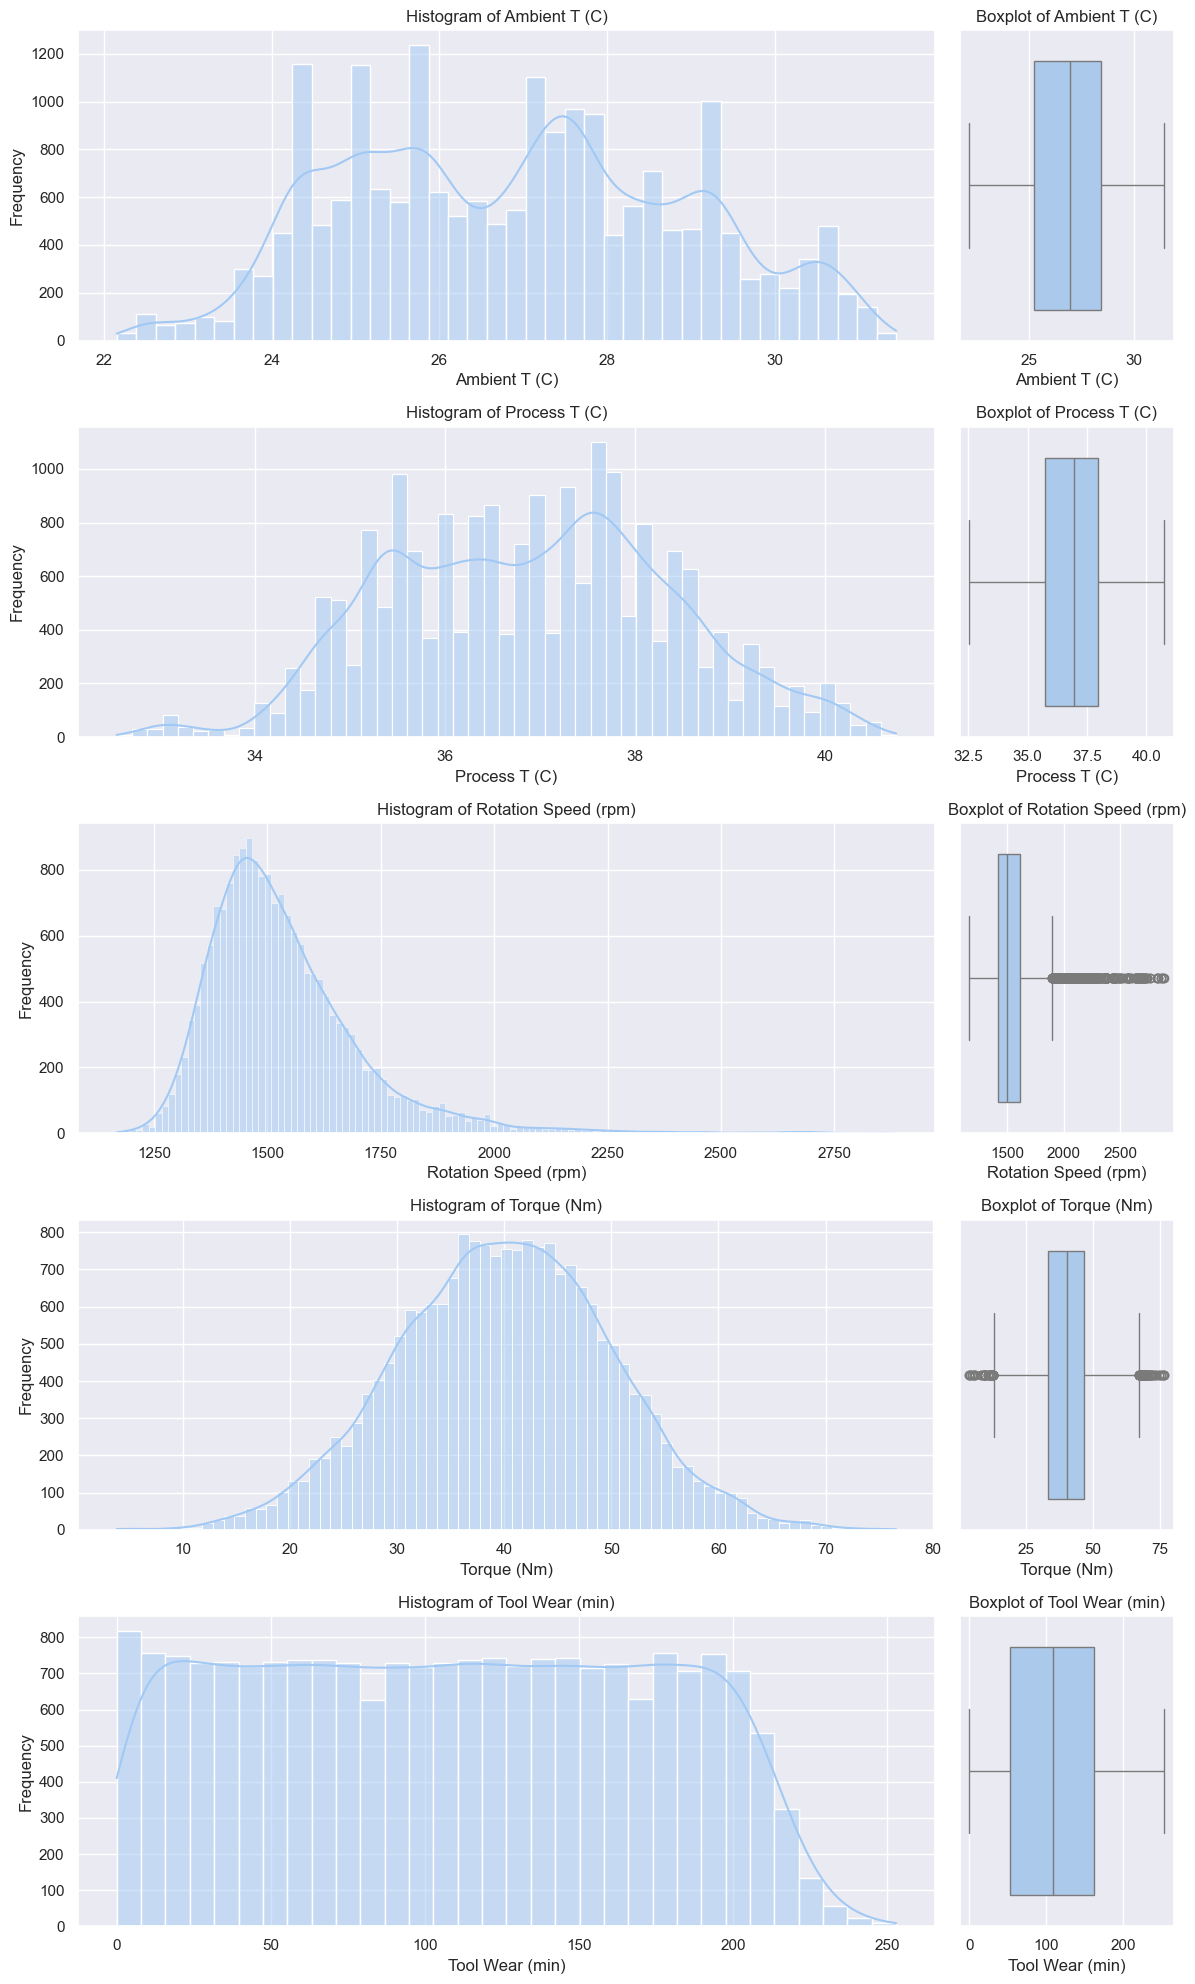

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical features to plot
features = ["Ambient T (C)", "Process T (C)", "Rotation Speed (rpm)", "Torque (Nm)", "Tool Wear (min)"]

# Create subplots
fig, axes = plt.subplots(len(features), 2, figsize=(12, 20), gridspec_kw={'width_ratios': [4, 1]})

for i, feature in enumerate(features):
    # Histogram for the distribution of the feature
    sns.histplot(df_copy[feature], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f"Histogram of {feature}")
    axes[i, 0].set_xlabel(feature)
    axes[i, 0].set_ylabel("Frequency")
    
    # Boxplot to observe skewness and outliers
    sns.boxplot(data=df_copy, x=feature, ax=axes[i, 1], orient="h")
    axes[i, 1].set_title(f"Boxplot of {feature}")
    axes[i, 1].set_xlabel(feature)

# Adjust layout
plt.tight_layout()
plt.show()


<mark>Skewness</mark>: Rotation Speed (rpm) and, to a lesser extent, Torque (Nm) have noticeable skewness. Transformations like log or square root might reduce skewness, which could improve model accuracy, particularly for models that assume normally distributed features (e.g., linear models).

<mark>Outliers</mark>: The box plots highlight that Rotation Speed has the most significant outliers. Handling these outliers (e.g., capping or removing) could help improve model stability if they negatively impact performance.

<mark>Feature Suitability</mark>: The distribution of these features is reasonably well-behaved, so these transformations or outlier-handling measures can be performed during preprocessing to make them more model-friendly.

## Step 2. Data preparation

##### First and  foremost, let me drop the column that is independent because independent variables are completely unrelated to the samples

In [79]:
prep_df = df_copy.drop(columns=["Unique ID", "Product ID"])
print(prep_df.columns)

Index(['Quality', 'Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)',
       'Torque (Nm)', 'Tool Wear (min)', 'Machine Status'],
      dtype='object')


Group data into Target and Features

In [81]:
#X stores all the features
#y is storing the target
X, y = prep_df.drop(['Machine Status'], axis=1),  prep_df['Machine Status']

#### 2.1 Spliting Data points

In order for us to evaluate our model after training it, we must have a testing set that has not been seen and changes have not been made. Therefore, below are the steps to split our dataset into train and test set by 80-20, setting stratify=y to ensure that the distribution of classes in y is the same as overall to prevent imbalanced distribuition and a biased model. 

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)
X_training = X_train.copy()

#### 2.2 Data preprocessing

From our EDA above, there are a few issues that we have to handle.

1)I have a categorical feature which i should change it to numerical feature <br>2) I have 3 features filled with unknown values which i have to handle <br>3) The distribution of normal and abnormal as a target variable is imbalanced where there is too huge amount of normal compared to abnormal <br>4) process T has overlapping target variable types when i was finding feature distribution <br>5) There are multiple different types of correlations between the features<br>6) there is no abnormal for 'h' in quality <br>7)steps neeeded to be taken to counter the skewness and outliers in the different variables

#### 2.21 (Handling unknown values)

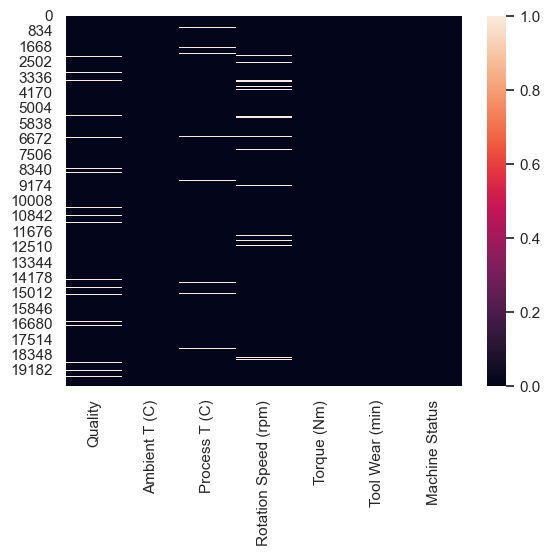

In [89]:
sns.heatmap(prep_df.isna())
plt.show()

As you can see, there are 3 features that contains missing values. There are several ways to deal with these mssing values so let me name all of them

1) Dropping rows or columns with missing values <mark>(used if there is a small percentage of rows with missing values)</mark>
2) Fowards/Backward fill <mark>(used when data has a temporal/sequential order)</mark>
3) Simple imputer using average(mean, mode or median) <mark>(Useful for continuous numerical features + categorical feature)</mark>
4) KNN/Iterative Imputer <mark>(Used if data is multivariate)</mark>

Since the feature, Quality, is catergorical, we should handle it separately and we will use Mode imputation

In [93]:
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

cols = ['Process T (C)', 'Rotation Speed (rpm)']

# Initialize imputers
imputer = KNNImputer()
quality_imputer = SimpleImputer(strategy='most_frequent')

# Impute continuous columns in X_training and X_test
X_training.loc[:, cols] = imputer.fit_transform(X_training[cols])
X_test.loc[:, cols] = imputer.transform(X_test[cols])

# Impute the Quality column in X_training and X_test 
# The .ravel() method converts the 2D array output of SimpleImputer to a 1D array, which can be assigned directly to the Quality column.
X_training['Quality'] = quality_imputer.fit_transform(X_training[['Quality']]).ravel()
X_test['Quality'] = quality_imputer.transform(X_test[['Quality']]).ravel()

# Check shapes to confirm row counts remain the same
print("X_training shape:", X_training.shape[0])
print("X_test shape:", X_test.shape[0])

print("X_training shape:", X_training.head())
print("X_test shape:", X_test.head())

X_train_imputed = X_training.copy()
X_test_imputed = X_test.copy()

X_training shape: 16000
X_test shape: 4000
X_training shape:       Quality  Ambient T (C)  Process T (C)  Rotation Speed (rpm)  \
12791       H          27.35          36.55                1416.0   
6582        L          28.35          37.35                1528.0   
16873       L          27.95          38.35                1478.0   
11391       L          25.85          37.15                2737.0   
4410        L          29.35          37.05                1586.0   

       Torque (Nm)  Tool Wear (min)  
12791         43.3               66  
6582          35.7              198  
16873         39.5               75  
11391          8.8              142  
4410          32.2               64  
X_test shape:       Quality  Ambient T (C)  Process T (C)  Rotation Speed (rpm)  \
3733        L          29.05          37.95                1470.0   
3059        M          26.85          35.85                1368.0   
18093       L          27.15          38.55                1511.0   
7874  

In [94]:
#chcek if there is any missing/unknown values left
X_train_imputed.isna().sum()

Quality                 0
Ambient T (C)           0
Process T (C)           0
Rotation Speed (rpm)    0
Torque (Nm)             0
Tool Wear (min)         0
dtype: int64

#### 2.22 (Converting categorical feature into numerical feature)

The reason behind this conversion is because categorical data cannot be typically handled by machine learning algorithms because most algorithms are primarily designed to operate with numerical data only. Thus, we have to encode them as numerical values

There are 2 ways we can encode this feature 

* One-Hot Encoding: For categories without ordinal relationships, this creates binary columns 
* Ordinal Encoding: If "Quality" has an inherent order  you can assign numeric values to each category.


In [99]:
# Define the order for the quality encoding
quality_order = [['L', 'M', 'H']] 

# Instantiate the encoder with specified categories
ordinal_encoder = OrdinalEncoder(categories=quality_order)

# Ensure no rows are missing before encoding
initial_train_rows = X_train_imputed.shape[0]
initial_test_rows = X_test_imputed.shape[0]

# Fit the encoder on the training data and transform both the training and test data
X_train_imputed['Quality_encoded'] = ordinal_encoder.fit_transform(X_train_imputed[['Quality']])
X_test_imputed['Quality_encoded'] = ordinal_encoder.transform(X_test_imputed[['Quality']])

# Check row counts to confirm they match initial counts
assert X_train_imputed.shape[0] == initial_train_rows, "Row count changed in X_train_imputed after encoding"
assert X_test_imputed.shape[0] == initial_test_rows, "Row count changed in X_test_imputed after encoding"

# Check the results
print("Training Set Quality Encoding:")
print(X_train_imputed[['Quality', 'Quality_encoded']].head())

print("\nTesting Set Quality Encoding:")
print(X_test_imputed[['Quality', 'Quality_encoded']].head())

print("\nTraining Set Row Count:", X_train_imputed.shape[0])
print("Testing Set Row Count:", X_test_imputed.shape[0])


print(X_train_imputed.columns)
print(X_test_imputed.columns)

Training Set Quality Encoding:
      Quality  Quality_encoded
12791       H              2.0
6582        L              0.0
16873       L              0.0
11391       L              0.0
4410        L              0.0

Testing Set Quality Encoding:
      Quality  Quality_encoded
3733        L              0.0
3059        M              1.0
18093       L              0.0
7874        L              0.0
3038        L              0.0

Training Set Row Count: 16000
Testing Set Row Count: 4000
Index(['Quality', 'Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)',
       'Torque (Nm)', 'Tool Wear (min)', 'Quality_encoded'],
      dtype='object')
Index(['Quality', 'Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)',
       'Torque (Nm)', 'Tool Wear (min)', 'Quality_encoded'],
      dtype='object')


In [100]:
#We now have to remove the 'Quality' column since we already have the 'Quality_encoded' column
X_train_imputed.drop(columns = 'Quality', inplace=True)
X_test_imputed.drop(columns = 'Quality', inplace=True)
print(X_train_imputed.columns)
print(X_test_imputed.columns)

Index(['Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)', 'Torque (Nm)',
       'Tool Wear (min)', 'Quality_encoded'],
      dtype='object')
Index(['Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)', 'Torque (Nm)',
       'Tool Wear (min)', 'Quality_encoded'],
      dtype='object')


From above, we have converted the quality feature to hold numerical data where <br>
L → 0<br>
M → 1<br>
H → 2

#### 2.23 (Transform skewed feature)

From the analysing of data above, I did mention that the row "Rotation Speed" was actually skewed and to handle this issue, we are to use transformation.

There are 2 types of transformation that we can use <br>
* Log and square root are simpler and typically effective for moderately skewed data.
* Box-Cox is more flexible but requires all values to be positive and can work well for more extreme skewness.


Since all the values in "Rotation Speed (npm)" are indeed positives, we will use Box-cox

In [106]:
from scipy import stats

# Apply Box-Cox transformation on 'Rotation Speed (rpm)'
X_train_imputed['Rotation_Speed_BoxCox'], lambda_train = stats.boxcox(X_train_imputed['Rotation Speed (rpm)'])
X_test_imputed['Rotation_Speed_BoxCox'] = stats.boxcox(X_test_imputed['Rotation Speed (rpm)'], lmbda=lambda_train)

# Check the skewness after the Box-Cox transformation
print("Original Skewness:", prep_df['Rotation Speed (rpm)'].skew())
print("Box-Cox Skewness (Train):", X_train_imputed['Rotation_Speed_BoxCox'].skew())
print("Box-Cox Skewness (Test):", X_test_imputed['Rotation_Speed_BoxCox'].skew())
X_train_imputed3 = X_train_imputed.drop(columns = ["Rotation Speed (rpm)"], inplace = False)
X_test_imputed3 = X_test_imputed.drop(columns = ["Rotation Speed (rpm)"], inplace = False)
# X_train_imputed3.shape[0]
# X_test_imputed3.shape[0]

Original Skewness: 1.9838541794424398
Box-Cox Skewness (Train): 0.0
Box-Cox Skewness (Test): 0.0


#### 2.24 (Handling outliers/Standardisation)

Theere are 2 ways we can standardize our data :<br>
* Standard Scalar
* Robust Scalar

Standard Scalar:<br>
It standardizes the features by transforming them into a distribution with Mean = 0, Standard Deviation = 1. It works well when the data is normally distributed or when features have a Gaussian-like distribution. Linnear models such as logistic regression will perform better when features are noramlly dustributed

Robust Scalar:<br>
It standardizes the features using the mdeian and interquartile range. Only use this if your data contains significant outliers since it uses the median and IQE which will influence less for extreme values

Since after taking note of what happened during EDA where we are dealing with multiple outliers, we have to take into consideration of how large the outliers will have in affecting our standard deviation. Thus we use Robust Scalar which is more suitable as it is less influenced because of the use of IQR

In [112]:

col = list(X_train_imputed3.columns)

# Initialize the RobustScaler
scale = RobustScaler()

# Fit the scaler on the training data and transform it
# using transform on the test set after fitting on the training set ensures that both sets are scaled using the same parameters, which is the correct procedure for machine learning to avoid data leakage.
X_train_scaled = X_train_imputed3.copy()
X_train_scaled[col] = scale.fit_transform(X_train_imputed3[col])

# Use the fitted scaler to transform the test data
X_test_scaled = X_test_imputed3.copy()
X_test_scaled[col] = scale.transform(X_test_imputed3[col])

# Now X_train_scaled and X_test_scaled contain the scaled data
X_train_scaled
# X_test_scaled

,Ambient T (C),Process T (C),Torque (Nm),Tool Wear (min),Quality_encoded,Rotation_Speed_BoxCox
12791,0.12500,-0.181818,0.238806,-0.381818,2.0,-0.562095
6582,0.43750,0.181818,-0.328358,0.818182,0.0,0.130544
16873,0.31250,0.636364,-0.044776,-0.300000,0.0,-0.151629
11391,-0.34375,0.090909,-2.335821,0.309091,0.0,2.259812
4410,0.75000,0.045455,-0.589552,-0.400000,0.0,0.412986
...,...,...,...,...,...,...
5302,1.18750,1.363636,-0.216418,0.790909,0.0,-0.074432
15451,0.93750,1.227273,0.649254,0.109091,0.0,-0.994783
18259,-0.28125,0.227273,-0.126866,0.345455,0.0,-0.194393
8027,0.15625,0.818182,0.358209,1.054545,0.0,0.473126


After scaling, I wanted to verify if the transformed features in both X_train_scaled and X_test_scaled follow the intended distributionand as you can see from the results below, this result suggests that the scaling process has worked effectively.The medians for all features between X_train_scaled and X_test_scaled are either exactly the same (0.0) or very close. Furthermore, The interquartile ranges (IQRs) are very close between the training and testing sets, with small variations

In [114]:
# Compare median and IQR of scaled features in X_train_scaled and X_test_scaled
train_summary = X_train_scaled.describe().loc[['50%', '25%', '75%']]
test_summary = X_test_scaled.describe().loc[['50%', '25%', '75%']]

print("Training set summary (median and IQR):")
print(train_summary)

print("\nTesting set summary (median and IQR):")
print(test_summary)

# Calculate IQR for each feature
train_iqr = train_summary.loc['75%'] - train_summary.loc['25%']
test_iqr = test_summary.loc['75%'] - test_summary.loc['25%']

# Display median and IQR side by side
comparison_df = pd.DataFrame({
    'Train Median': train_summary.loc['50%'],
    'Test Median': test_summary.loc['50%'],
    'Train IQR': train_iqr,
    'Test IQR': test_iqr
})

print("\nMedian and IQR comparison:")
print(comparison_df)


Training set summary (median and IQR):
     Ambient T (C)  Process T (C)  Torque (Nm)  Tool Wear (min)  \
50%        0.00000       0.000000     0.000000              0.0   
25%       -0.53125      -0.545455    -0.507463             -0.5   
75%        0.46875       0.454545     0.492537              0.5   

     Quality_encoded  Rotation_Speed_BoxCox  
50%              0.0               0.000000  
25%              0.0              -0.490784  
75%              1.0               0.509216  

Testing set summary (median and IQR):
     Ambient T (C)  Process T (C)  Torque (Nm)  Tool Wear (min)  \
50%        0.00000       0.000000     0.000000        -0.027273   
25%       -0.53125      -0.563636    -0.544776        -0.509091   
75%        0.43750       0.454545     0.507463         0.490909   

     Quality_encoded  Rotation_Speed_BoxCox  
50%              0.0               0.000000  
25%              0.0              -0.471542  
75%              1.0               0.513457  

Median and IQR 

In [115]:
# Check before standardization
print("Before Standardization:")
print("Mean:", X_train_imputed3.mean())
print("Standard Deviation:", X_train_imputed3.std())

# Check after standardization
print("\nAfter Standardization:")
print("Mean:", X_train_scaled.mean())
print("Standard Deviation:", X_train_scaled.std())

Before Standardization:
Mean: Ambient T (C)             26.909819
Process T (C)             36.907667
Torque (Nm)               40.011950
Tool Wear (min)          108.170625
Quality_encoded            0.470313
Rotation_Speed_BoxCox      0.313812
dtype: float64
Standard Deviation: Ambient T (C)            1.999487e+00
Process T (C)            1.469087e+00
Torque (Nm)              9.925656e+00
Tool Wear (min)          6.366701e+01
Quality_encoded          6.613592e-01
Rotation_Speed_BoxCox    6.707554e-12
dtype: float64

After Standardization:
Mean: Ambient T (C)           -0.012557
Process T (C)           -0.019242
Torque (Nm)             -0.006571
Tool Wear (min)          0.001551
Quality_encoded          0.470313
Rotation_Speed_BoxCox    0.006573
dtype: float64
Standard Deviation: Ambient T (C)            0.624840
Process T (C)            0.667767
Torque (Nm)              0.740721
Tool Wear (min)          0.578791
Quality_encoded          0.661359
Rotation_Speed_BoxCox    0.755784
dty

From above, we can see that standardization has worked successfully where the features are centered around 0 and scaled to a standard deviation close to 1

#### 2.25 (Balancing our target variable)

Lets recall that in our EDA, we found out that our target variable had a clear imbalanced distribution where the machine status of "normal" is 96.6% which is about 28 times more than the machine status of "Abnormal" of 3.4%. Thus we have to resample our data

There are several ways to resample our data:<br>
1) Random Under-Sampling
2) Random Over-Sampling
3) Random Combined-Sampling
4) SMOTE

We will use SMOTE to generate more synthetic samples of the minority class. It works by creating synthetic samples based on the feature space of the minority class instances.

In [121]:
# Define the SMOTE object
smote = SMOTE(sampling_strategy='auto', random_state=42)  # 'auto' means balancing the dataset to equal classes

# Apply SMOTE to the training data (X_train and y_train)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Before: ",X_training.shape)
print("After: ",X_resampled.shape)

Before:  (16000, 6)
After:  (30916, 6)


Class distribution before SMOTE:
Machine Status
0    15458
1      542
Name: count, dtype: int64
Class distribution after SMOTE:
Machine Status
0    15458
1    15458
Name: count, dtype: int64


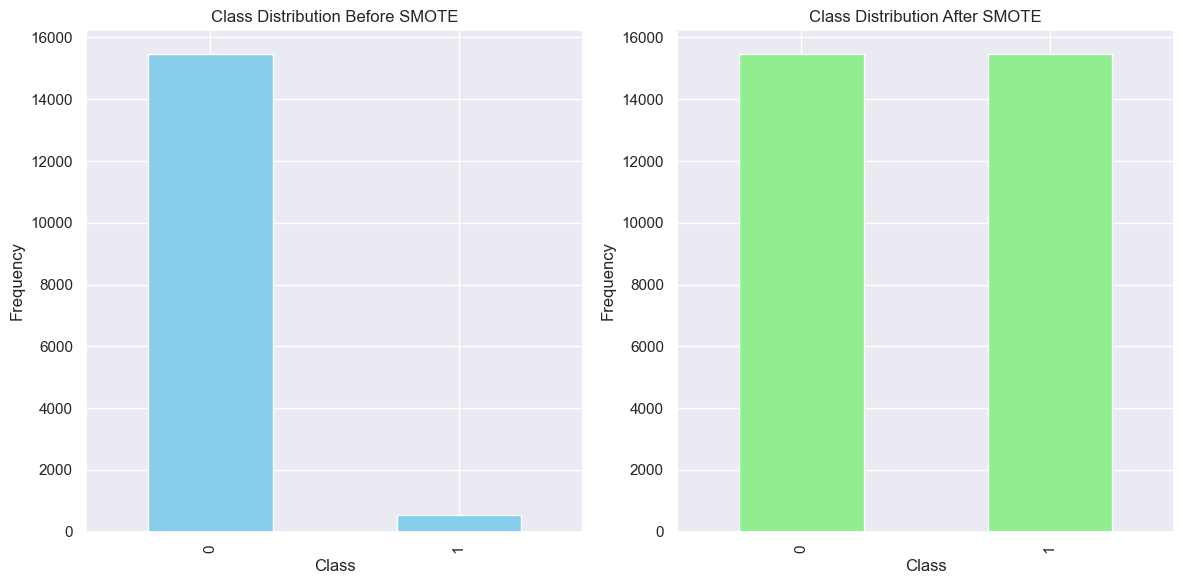

0    0
1    0
2    0
3    1
4    0
Name: Machine Status, dtype: int32


In [122]:
# Show the distribution of the target variable before SMOTE
print("Class distribution before SMOTE:")
print(y_train.value_counts())

# Show the distribution of the target variable after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# Plot before SMOTE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', color='skyblue', title='Class Distribution Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')

# Plot after SMOTE
plt.subplot(1, 2, 2)
pd.Series(y_resampled).value_counts().plot(kind='bar', color='lightgreen', title='Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
print(y_resampled.head())

#### 2.26 (Feature selection/ engineering)

First and foremost, we have to identify features that might provide redundant information. This can normally be seen when 2 features are highly correlated. The reason, being that they both will share similar information about the target varibale which can lead to multicollinearity

In [125]:
# Check correlations
corr_matrix = X_resampled.corr()
high_corr_pairs = corr_matrix[abs(corr_matrix) > 0.8]
print(high_corr_pairs)


                       Ambient T (C)  Process T (C)  Torque (Nm)  \
Ambient T (C)               1.000000       0.854825          NaN   
Process T (C)               0.854825       1.000000          NaN   
Torque (Nm)                      NaN            NaN     1.000000   
Tool Wear (min)                  NaN            NaN          NaN   
Quality_encoded                  NaN            NaN          NaN   
Rotation_Speed_BoxCox            NaN            NaN    -0.906084   

                       Tool Wear (min)  Quality_encoded  Rotation_Speed_BoxCox  
Ambient T (C)                      NaN              NaN                    NaN  
Process T (C)                      NaN              NaN                    NaN  
Torque (Nm)                        NaN              NaN              -0.906084  
Tool Wear (min)                    1.0              NaN                    NaN  
Quality_encoded                    NaN              1.0                    NaN  
Rotation_Speed_BoxCox              Na

From above, we can summarise our points in the following:<br>
* Ambient T (C) and Process T (C) have a high positive correlation (0.864961)
* Torque (Nm) and Rotation_Speed_BoxCox have a strong negative correlation (-0.880625)
* Tool Wear (min) and Quality_encoded show no significant correlation with other features (mostly NaNs or 1.0 with themselves).
* The presence of NaN values suggests that some features don't have enough data points or share no measurable linear relationship with others

#### Handle highly correlated features

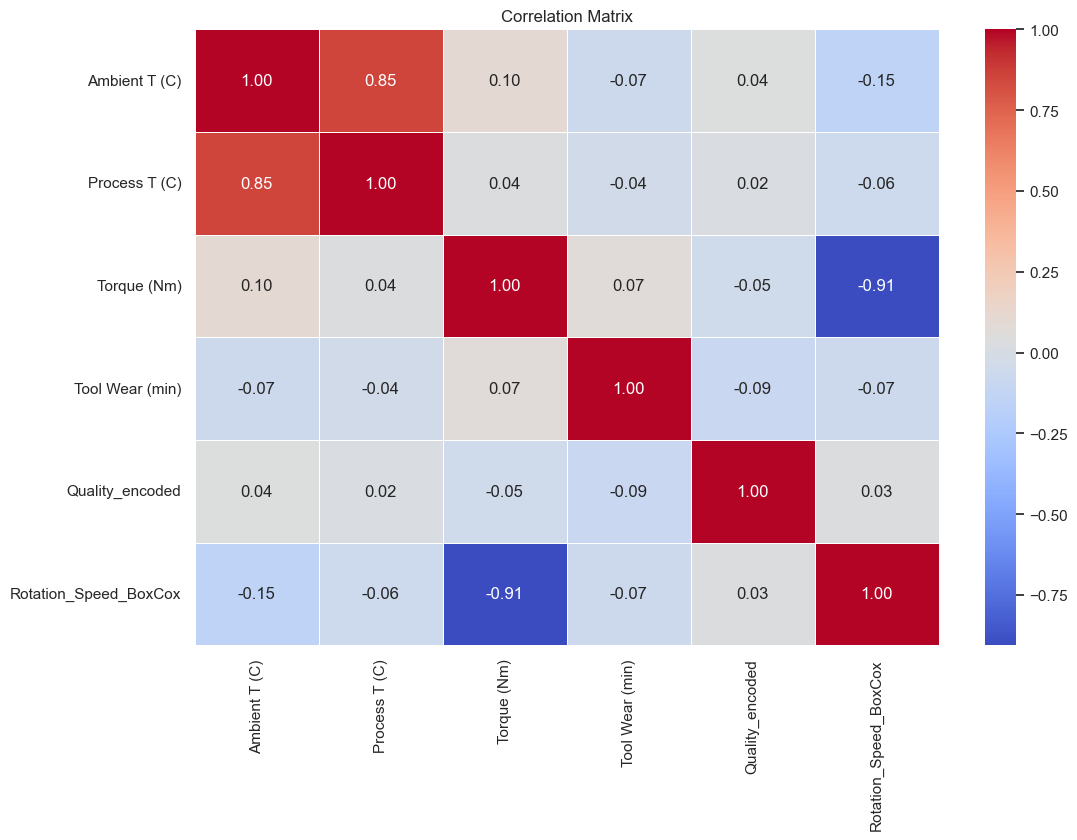

Dropped columns due to high correlation: {'Rotation_Speed_BoxCox'}


In [128]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculate correlation matrix
corr_matrix = X_resampled.corr()

# Plot the correlation matrix heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Identify columns with high correlation (greater than 0.9)
threshold = 0.9
to_drop = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            to_drop.add(colname)

# Drop highly correlated features
X_train_scaled_dropped = X_resampled.drop(columns=to_drop)
X_test_scaled_dropped = X_resampled.drop(columns=to_drop)


print(f"Dropped columns due to high correlation: {to_drop}")


From above, the dropped columns remains as 'set()' meaning that no features were dropped. This is due to the fact that  meaning no highly correlated features were found that needed to be removed. 

## Step 3. Model Selection

To find the best model, we first have to train all the different models available to us to see which model will yield the best results from the metrics

#### 3.1 (Creation of pipeline)

In [133]:
base_steps = [
    ("impute", SimpleImputer(strategy="mean")),
    ("standardize", StandardScaler())
]

base_steps_LEN = len(base_steps) -1


This pipeline ensures that all the preprocessing steps (imputation, transformation, scaling, balancing) are applied in sequence, followed by the model training process.

#### 3.2 (Creating dummy model)

What the dummy model does is that it acts as a baseline model for ocmparison to our other meodels. It will just be acting as a benchmark for other models since it is interpretable.

In [137]:
# Define scoring metrics
scoring_methods = ["accuracy", "recall", "f1", "roc_auc"]

# Set up the pipeline with a DummyClassifier
base_steps[base_steps_LEN] = ("model", DummyClassifier(strategy="uniform"))
dummy = IMBPipeline(steps=base_steps)
dummy.fit(X_resampled, y_resampled)

# Display baseline accuracy score
print(f"Baseline Accuracy Score: {dummy.score(X_resampled, y_resampled)}")

# Perform cross-validation
scores = cross_validate(
    dummy,
    X_resampled,
    y_resampled,
    cv=10,
    scoring=scoring_methods,
    n_jobs=4,
    return_train_score=True
)

# Convert scores to a DataFrame
dummy_model_score = pd.DataFrame(scores)

# Add a row for the mean of each metric
mean_row = pd.DataFrame([dummy_model_score.mean()], columns=dummy_model_score.columns, index=["Mean"])
dummy_model_score = pd.concat([dummy_model_score, mean_row])

# Highlight min and max values for each column
display(dummy_model_score.style.apply(
    lambda x: [
        "background-color: red; color: white" if v else "" for v in x == x.min()
    ]
).apply(
    lambda x: [
        "background-color: green; color: white" if v else "" for v in x == x.max()
    ]
))

Baseline Accuracy Score: 0.4950511062233148


,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
0,0.010236,0.010361,0.504204,0.497700,0.490944,0.498347,0.497542,0.498025,0.500000,0.500000
1,0.012430,0.008166,0.506145,0.502911,0.499353,0.506757,0.502768,0.504815,0.500000,0.500000
2,0.012430,0.008166,0.506145,0.503271,0.488357,0.506829,0.497201,0.505032,0.500000,0.500000
3,0.012430,0.008166,0.508732,0.501078,0.509056,0.501078,0.508891,0.501078,0.500000,0.500000
4,0.006535,0.013563,0.499030,0.500863,0.507762,0.499066,0.503366,0.499964,0.500000,0.500000
5,0.013563,0.010759,0.487710,0.498670,0.487710,0.504313,0.487710,0.501483,0.500000,0.500000
6,0.012210,0.008364,0.495309,0.500593,0.509385,0.498167,0.502234,0.499388,0.500000,0.500000
7,0.012639,0.010725,0.502103,0.503181,0.488673,0.502048,0.495244,0.502626,0.500000,0.500000
8,0.009186,0.012357,0.506632,0.498616,0.508409,0.499353,0.507588,0.498976,0.500000,0.500000
9,0.007856,0.010223,0.504368,0.499910,0.505175,0.498994,0.504848,0.499442,0.500000,0.500000


##### We will also employ the 4 metrics that will measure and determine the effectiveness of our model through providing inisghts into different elements of model performance 

Reference: https://www.deepchecks.com/f1-score-accuracy-roc-auc-and-pr-auc-metrics-for-models/

1) <mark>Accuracy</mark><br>
- measures the proportion of correct predictions made by a model over the total number of predictions made. It is particularly useful when the classes are balanced, meaning there are roughly equal numbers of positive and negative samples.

2) <mark>Recall</mark><br>
-proportion of true positive predictions from all actual positive samples in the dataset. It measures the model’s ability to identify all positive instances and is critical when the cost of false negatives is high.

3) <mark>f1</mark><br>
- measure of a model’s accuracy that takes into account both precision and recall, where the goal is to classify instances correctly as positive or negative.Precision measures how many of the predicted positive instances were actually positive, while recall measures how many of the actual positive instances were correctly predicted. 

4) <mark>roc_auc</mark><br>
-  used to evaluate the performance of binary classification models. It is a plot of the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings, and it is created by varying the threshold to predict a positive or negative outcome and plotting the TPR against the FPR for each threshold. 

In [144]:
# Define evaluation metrics
scoring_methods = {
    "accuracy": make_scorer(accuracy_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score),
    "roc_auc": make_scorer(roc_auc_score)
}

# Define models
models = [
    ("Dummy", DummyClassifier(strategy="uniform")),
    ("KNeighborsClassifier", KNeighborsClassifier()),
    ("RandomForestClassifier", RandomForestClassifier()),
    ("SVC", SVC()),
    ("AdaBoostClassifier", AdaBoostClassifier()),
    ("LogisticRegression", LogisticRegression()),
    ("DecisionTreeClassifier", DecisionTreeClassifier()),
    ("GradientBoostingClassifier", GradientBoostingClassifier()),
    ("Perceptron", Perceptron()),
    ("ExtraTreesClassifier", ExtraTreesClassifier()),
    ("GaussianNB", GaussianNB()),
    ("RidgeClassifier", RidgeClassifier()),
    ("RidgeClassifierCV", RidgeClassifierCV()),
]


,test_accuracy,test_recall,test_f1,test_roc_auc
Model,,,,
Dummy,0.501844,0.498770,0.500292,0.501843
KNeighborsClassifier,0.977229,0.998577,0.977707,0.977229
RandomForestClassifier,0.991493,0.992237,0.991499,0.991493
SVC,0.943945,0.964937,0.945101,0.943945
AdaBoostClassifier,0.924796,0.929939,0.925182,0.924796
LogisticRegression,0.774712,0.795382,0.779265,0.774713
DecisionTreeClassifier,0.983795,0.984021,0.983797,0.983795
GradientBoostingClassifier,0.950414,0.967072,0.951230,0.950414
Perceptron,0.608292,0.498568,0.542528,0.608290


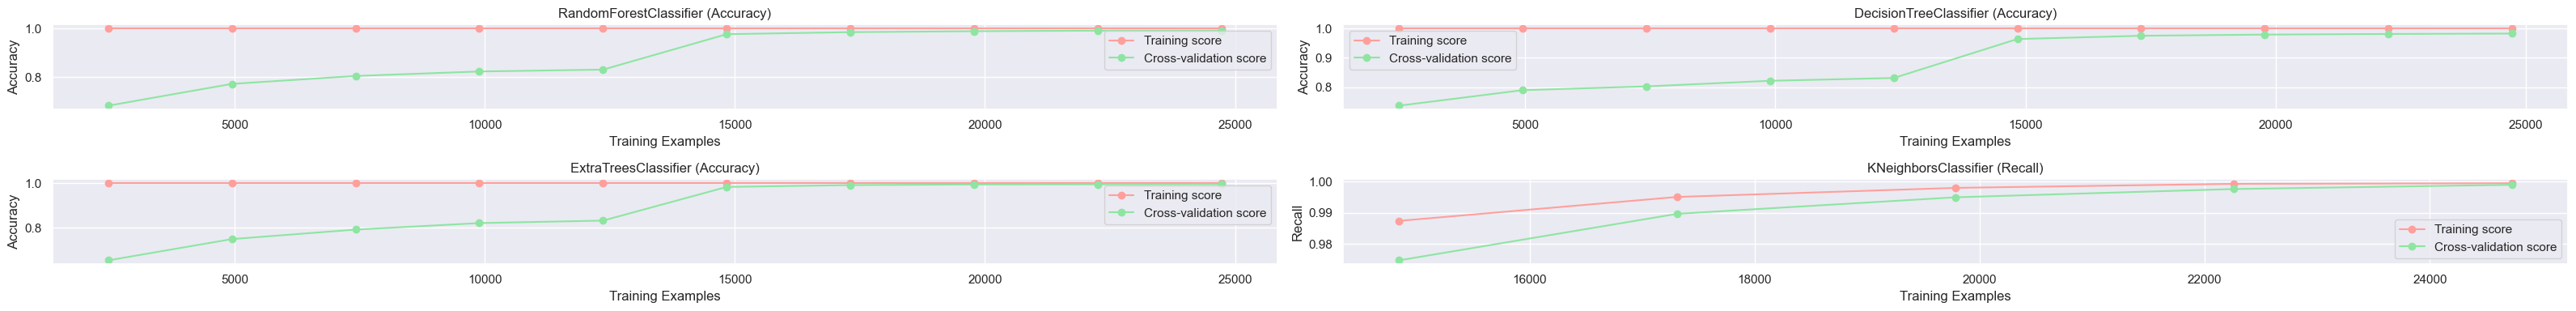

In [145]:
# Function to plot learning curves in a 4x3 grid
def plot_learning_curves_grid(X_train, y_train, models, scoring_methods):
    n_plots = len(models) * len(scoring_methods)
    n_rows = (n_plots + 1) // 2  # Two plots per row
    fig, axes = plt.subplots(n_rows, 2, figsize=(32, n_rows * 2))

    axes = axes.flatten()  # Flatten to iterate over each subplot
    plot_idx = 0

    for name, model in models:
        for scoring in scoring_methods.keys():
            pipeline_steps = base_steps[:-1] + [("model", model)]
            pipeline = IMBPipeline(steps=pipeline_steps)

            # Compute learning curve data
            train_sizes, train_scores, test_scores = learning_curve(
                pipeline, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1,
                train_sizes=np.linspace(0.1, 1.0, 10)
            )
            train_scores_mean = np.mean(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)

            # Plot on designated subplot
            ax = axes[plot_idx]
            ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
            ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

            ax.set_title(f"{name} ({scoring.capitalize()})")
            ax.set_xlabel("Training Examples")
            ax.set_ylabel(scoring.capitalize())
            ax.grid(True)  # Add grid lines
            ax.legend(loc="best")
            plot_idx += 1

            # Stop if we've filled the grid (4x3 = 12 plots)
            if plot_idx >= len(axes):
                break
        if plot_idx >= len(axes):
            break

    plt.tight_layout()
    plt.show()

# StratifiedKFold cross-validation setup
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train each model without hyperparameter tuning
all_results = pd.DataFrame()
for name, model in models:
    # Create a pipeline with the base steps and the current model
    pipeline_steps = base_steps[:-1] + [("model", model)]
    pipeline = IMBPipeline(steps=pipeline_steps)

    # Fit the pipeline and evaluate using cross-validation
    scores = cross_validate(
        pipeline,
        X_resampled,
        y_resampled,
        cv=stratified_cv,
        scoring=scoring_methods,
        return_train_score=True,
        n_jobs=-1,
        error_score="raise"
    )
    
    # Summarize cross-validation results
    result_df = pd.DataFrame(scores).mean().to_frame().T
    result_df["Model"] = name
    all_results = pd.concat([all_results, result_df], ignore_index=True)

# Set the model name as index for easy comparison
all_results.set_index("Model", inplace=True)

# Display the mean cross-validation scores for all models
all_results = all_results.filter(regex="test_")  # Filter test scores only for readability
display(all_results.style.highlight_max(color="lightgreen").highlight_min(color="lightcoral"))

# For each scoring metric, select the top 3 models
top_models = {}
for scoring in scoring_methods.keys():
    top_models[scoring] = all_results[f"test_{scoring}"].sort_values(ascending=False).head(3).index.tolist()

# Plot learning curves for the top 3 models only
def plot_learning_curves_grid_top_models(X_train, y_train, models, scoring_methods, top_models):
    n_plots = len(scoring_methods)
    n_rows = (n_plots + 1) // 2  # Two plots per row
    fig, axes = plt.subplots(n_rows, 2, figsize=(32, n_rows * 2))

    axes = axes.flatten()  # Flatten to iterate over each subplot
    plot_idx = 0

    for scoring in scoring_methods.keys():
        for name, model in models:
            if name in top_models[scoring]:
                pipeline_steps = base_steps[:-1] + [("model", model)]
                pipeline = IMBPipeline(steps=pipeline_steps)

                # Compute learning curve data
                train_sizes, train_scores, test_scores = learning_curve(
                    pipeline, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1,
                    train_sizes=np.linspace(0.1, 1.0, 10)
                )
                train_scores_mean = np.mean(train_scores, axis=1)
                test_scores_mean = np.mean(test_scores, axis=1)

                # Plot on designated subplot
                ax = axes[plot_idx]
                ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
                ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

                ax.set_title(f"{name} ({scoring.capitalize()})")
                ax.set_xlabel("Training Examples")
                ax.set_ylabel(scoring.capitalize())
                ax.grid(True)  # Add grid lines
                ax.legend(loc="best")
                plot_idx += 1

                # Stop if we've filled the grid (4x3 = 12 plots)
                if plot_idx >= len(axes):
                    break
        if plot_idx >= len(axes):
            break

    plt.tight_layout()
    plt.show()

# Call the function to plot learning curves for the top 3 models
plot_learning_curves_grid_top_models(X_resampled, y_resampled, models, scoring_methods, top_models)

Training and evaluating: Dummy
Training and evaluating: KNeighborsClassifier
Training and evaluating: RandomForestClassifier
Training and evaluating: SVC
Training and evaluating: AdaBoostClassifier


C:\PDAS\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training and evaluating: LogisticRegression
Training and evaluating: DecisionTreeClassifier
Training and evaluating: GradientBoostingClassifier
Training and evaluating: Perceptron
Training and evaluating: ExtraTreesClassifier
Training and evaluating: GaussianNB
Training and evaluating: RidgeClassifier
Training and evaluating: RidgeClassifierCV


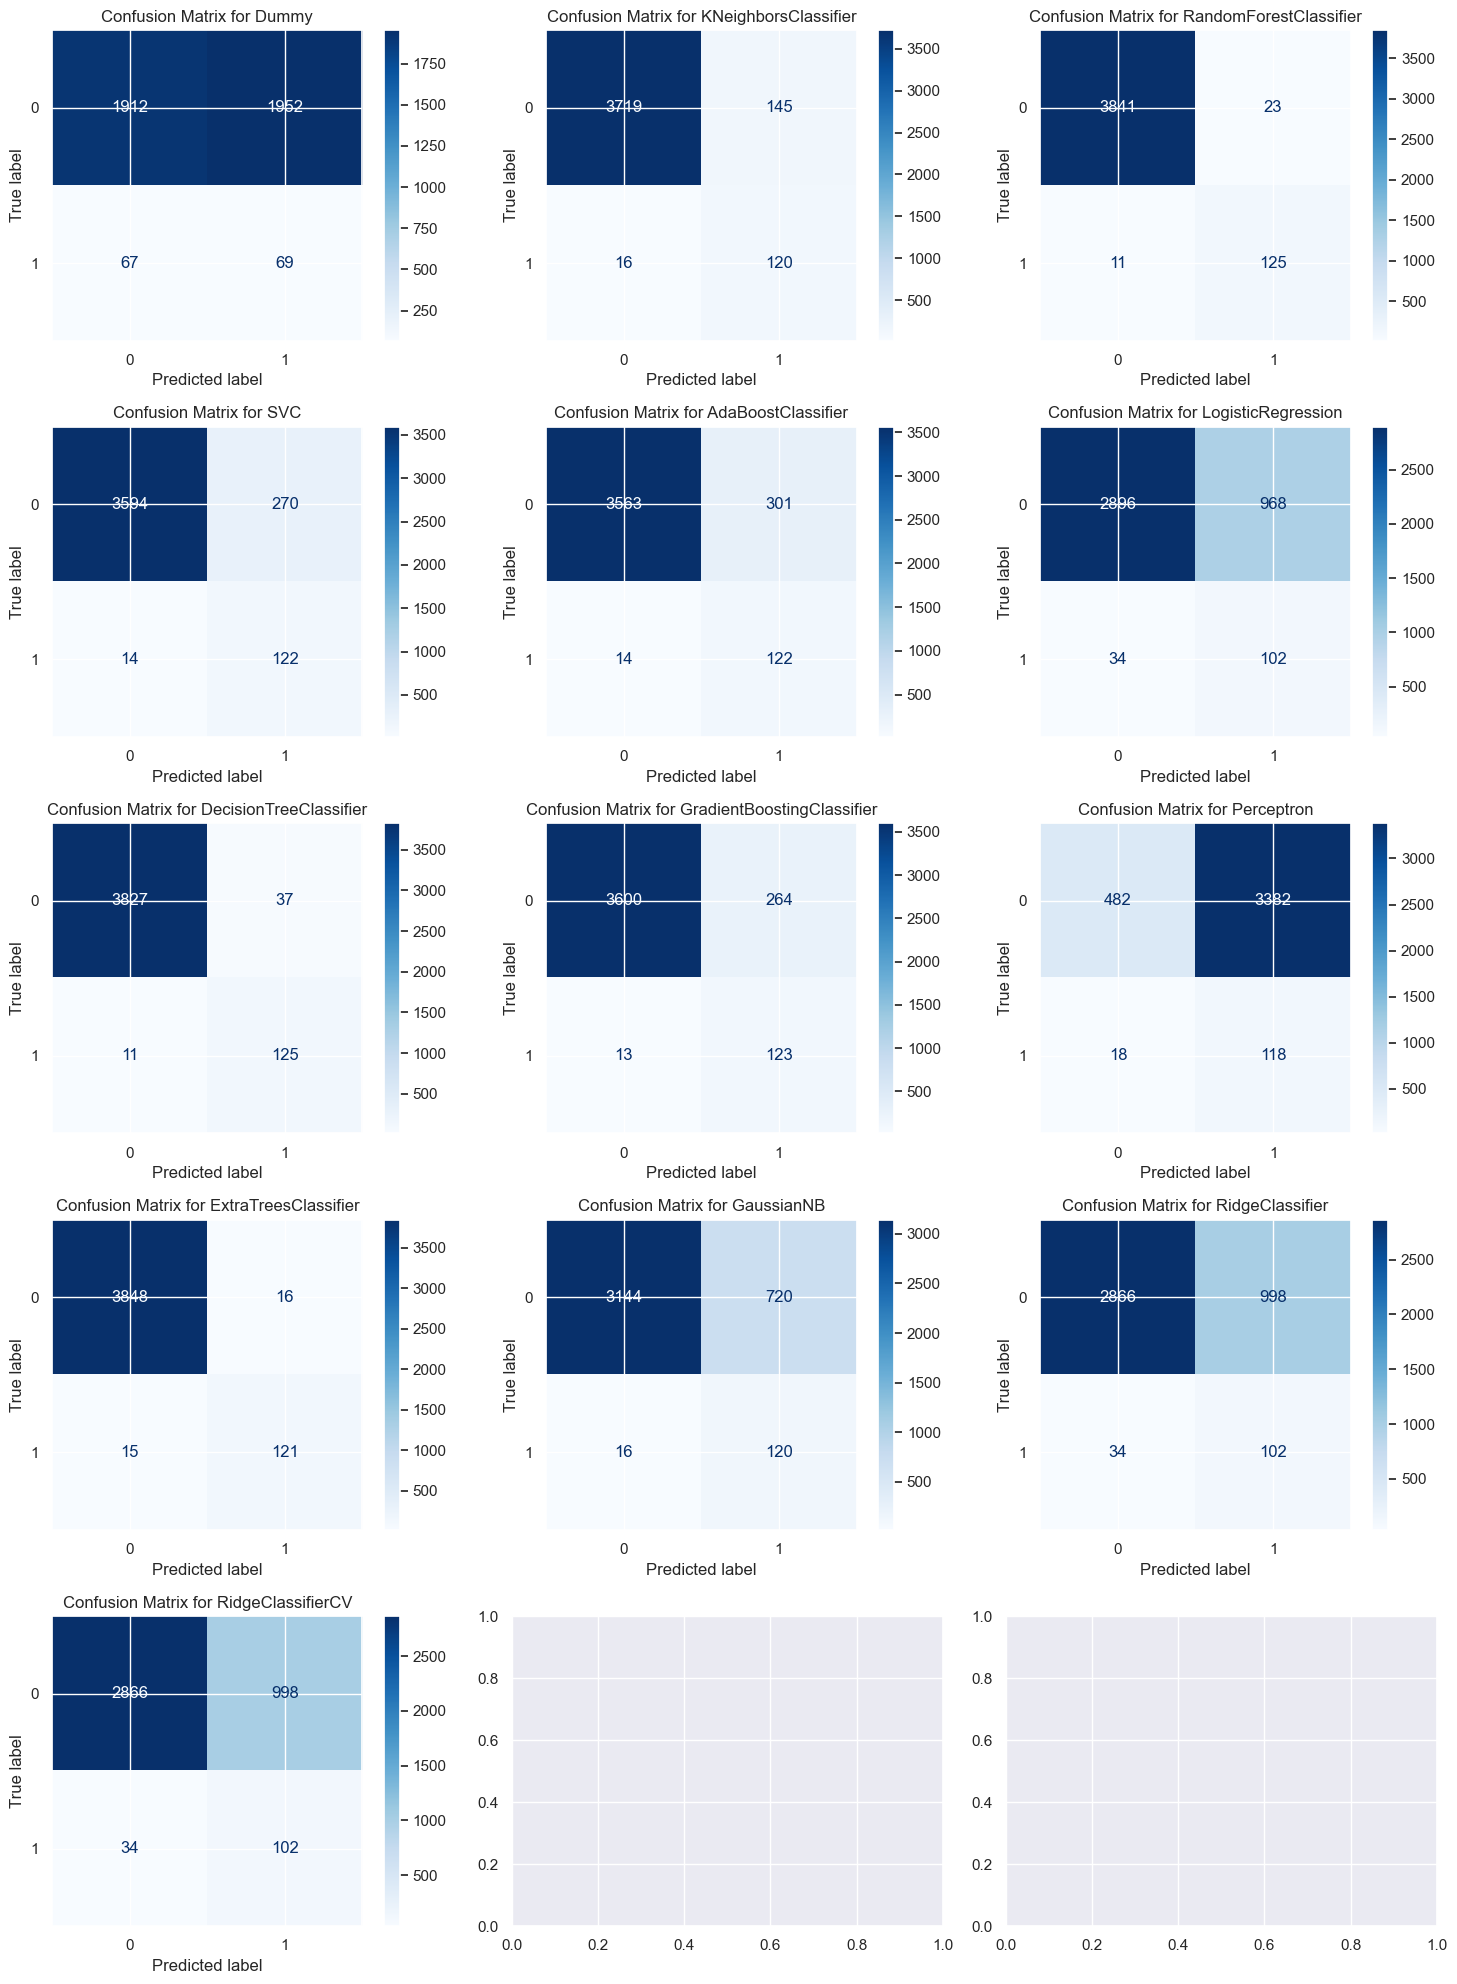

In [146]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set up the figure with a grid of 5 rows and 3 columns
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))
axes = axes.ravel()  # Flatten the 2D array of axes for easy indexing

# Loop through each model
for idx, (name, model) in enumerate(models):
    print(f"Training and evaluating: {name}")
    
    # Train the model
    model.fit(X_resampled, y_resampled)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Display the confusion matrix on the appropriate axis
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues, ax=axes[idx])
    axes[idx].set_title(f"Confusion Matrix for {name}")

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


From the results above, we can make a lot of conclusions.

1) Top 3 Models for Accuracy (test_accuracy):<br>
* RandomForestClassifier 
* ExtraTreesClassifier
* KNeighborsClassifier 
<br>
<br>
2) Top 3 Models for Recall (test_recall):>br>
* GradientBoostingClassifier 
* SVC 
* RandomForestClassifier 
<br>
<br>
3) Top 3 Models for F1 Score (test_f1):
* RandomForestClassifier 
* ExtraTreesClassifier 
* DecisionTreeClassifier 
<br>
<br>
4) Top 3 Models for ROC AUC (test_roc_auc):
* RandomForestClassifier 
* GradientBoostingClassifier 
* KNeighborsClassifier

In conclusion, ExtraTreesClassifier is likely the best overall model for my dataset based on its consistent high performance across all metrics.RandomForestClassifier is also highly competitive especially with its high recall score. KNeighborsClassifier also offers good recall scpre but is not as strong in recall or F1, meaning it might struggle with detecting all positive class instances.

#### I have to check for overfitting or underfitting

In [151]:
# Fit the model to the resampled training data
model.fit(X_resampled, y_resampled)

# Make predictions on the training data (X_resampled)
y_train_pred = model.predict(X_resampled)  

# Make predictions on the test data (X_test)
y_test_pred = model.predict(X_test_scaled)  


In [152]:
# Calculate metrics for training data
train_accuracy = accuracy_score(y_resampled, y_train_pred)
train_f1 = f1_score(y_resampled, y_train_pred, average='weighted')
train_recall = recall_score(y_resampled, y_train_pred, average='weighted')
train_precision = precision_score(y_resampled, y_train_pred, average='weighted')

# Calculate metrics for test data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')

# Print the metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"Precision: {train_precision:.4f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Precision: {test_precision:.4f}")

Training Metrics:
Accuracy: 0.7738
F1 Score: 0.7736
Recall: 0.7738
Precision: 0.7747

Test Metrics:
Accuracy: 0.7420
F1 Score: 0.8242
Recall: 0.7420
Precision: 0.9578


#### From above, we can notice multiple things:
1) The testing data had a way better metrics result as compared to the training data. I have found the sole reason for this which leads back to how i resampled and balanced the classes for y_train but not y_test.
- Because  dataset has a severe imbalance between the "normal" and "abnormal" machine statuses (96.6% "normal" and only 3.4% "abnormal, it proves the point that 'High accuracy can often be misleading in imbalanced datasets, because a model could achieve high accuracy simply by predicting the majority class (normal) most of the time.'

2) Consistency Across Models:
- Models like KNeighborsClassifier and RandomForestClassifier perform better than the Dummy Classifier, and their results seem consistent. This suggests that the models are learning meaningful patterns instead of just memorizing the training data.

In conclusion, we can see that the slightly higher test accuracy, especially when combined with the other metrics, suggests my model is generalizing well and not overfitting. It also indicates that it is effectively identifying the minority class ("abnormal").

In [155]:
model = RandomForestClassifier()
model.fit(X_resampled, y_resampled)

# Extract feature importance
feature_importance = pd.DataFrame({
    'Feature': X_resampled.columns,  
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

                 Feature  Importance
2            Torque (Nm)    0.317505
5  Rotation_Speed_BoxCox    0.283688
3        Tool Wear (min)    0.221859
0          Ambient T (C)    0.096154
1          Process T (C)    0.064428
4        Quality_encoded    0.016367


#### Hypertuning our best performing model

Hyperparameter tuning allows for the most optimal configuration of parameter for my model where it improves in 3 different aspects<br>
* The number of trees in the forest.
* The maximum depth of each tree.
* The minimum samples required to split a node, etc.

We will also be using Grid Serach CV <br>
* GridSearchCV is a tool for hyperparameter tuning in machine learning models.
* It works by exhaustively searching through a specified set of hyperparameter combinations to find the best one based on a chosen evaluation metric (e.g., accuracy).
* It performs cross-validation for each combination to ensure reliable performance and returns the configuration that performs best on average.

First and foremost, let us find out the list of possible hyperparameters to tune

In [160]:
list(SVC().get_params().keys())

['C',
 'break_ties',
 'cache_size',
 'class_weight',
 'coef0',
 'decision_function_shape',
 'degree',
 'gamma',
 'kernel',
 'max_iter',
 'probability',
 'random_state',
 'shrinking',
 'tol',
 'verbose']

Since there are multiple options to choose from, we will only choose the best and most common to tuned ones which are <br>
1) n_estimators: Controls the number of trees in the forest. More trees usually mean better performance, but also longer training time.<br>
2) max_depth: Deeper trees capture more complexity but can lead to overfitting. You may want to tune it to find the right balance.

In [162]:
# Initialize the Extra Trees Classifier
etc = ExtraTreesClassifier(random_state=42)

# Parameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
}

# Grid Search CV
grid_search = GridSearchCV(estimator=etc, param_grid=param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

# Get the best estimator and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': None, 'n_estimators': 100}


In [163]:
# Evaluate before tuning
etc.fit(X_resampled, y_resampled)
y_pred_before = etc.predict(X_test_scaled)
metrics_before = {
    'Accuracy': accuracy_score(y_test, y_pred_before),
    'Precision': precision_score(y_test, y_pred_before),
    'Recall': recall_score(y_test, y_pred_before),
    'F1 Score': f1_score(y_test, y_pred_before)
}

# Evaluate after tuning
y_pred_after = best_model.predict(X_test_scaled)
metrics_after = {
    'Accuracy': accuracy_score(y_test, y_pred_after),
    'Precision': precision_score(y_test, y_pred_after),
    'Recall': recall_score(y_test, y_pred_after),
    'F1 Score': f1_score(y_test, y_pred_after)
}

# Display the comparison
print("Metrics Before Tuning:", metrics_before)
print("Metrics After Tuning:", metrics_after)

# Display confusion matrices
print("\nConfusion Matrix Before Tuning:")
print(confusion_matrix(y_test, y_pred_before))

print("\nConfusion Matrix After Tuning:")
print(confusion_matrix(y_test, y_pred_after))

Metrics Before Tuning: {'Accuracy': 0.99375, 'Precision': 0.9172932330827067, 'Recall': 0.8970588235294118, 'F1 Score': 0.9070631970260223}
Metrics After Tuning: {'Accuracy': 0.99375, 'Precision': 0.9172932330827067, 'Recall': 0.8970588235294118, 'F1 Score': 0.9070631970260223}

Confusion Matrix Before Tuning:
[[3853   11]
 [  14  122]]

Confusion Matrix After Tuning:
[[3853   11]
 [  14  122]]


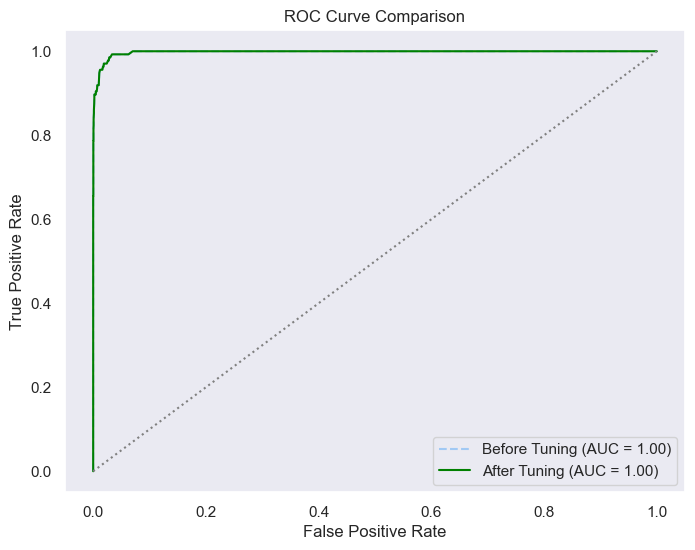

In [164]:
from sklearn.metrics import roc_curve, auc
# Get probabilities for ROC
y_prob_before = etc.predict_proba(X_test_scaled)[:, 1]
y_prob_after = best_model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and AUC for both models
fpr_before, tpr_before, _ = roc_curve(y_test, y_prob_before)
fpr_after, tpr_after, _ = roc_curve(y_test, y_prob_after)

roc_auc_before = auc(fpr_before, tpr_before)
roc_auc_after = auc(fpr_after, tpr_after)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_before, tpr_before, label=f'Before Tuning (AUC = {roc_auc_before:.2f})', linestyle='--')
plt.plot(fpr_after, tpr_after, label=f'After Tuning (AUC = {roc_auc_after:.2f})', color='green')
plt.plot([0, 1], [0, 1], color='gray', linestyle=':')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

In [165]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Perform cross-validation
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5, scoring='accuracy')  # Adjust cv for number of folds

print("\nCross-validation Accuracy Scores:")
print(cv_scores)
print("\nMean Cross-validation Accuracy:", np.mean(cv_scores))

cv_auc = cross_val_score(best_model, X_resampled, y_resampled, cv=5, scoring='roc_auc')
print("\nMean Cross-validation AUC:", np.mean(cv_auc))



Cross-validation Accuracy Scores:
[0.99676585 0.99433932 0.99579492 0.99417758 0.99660359]

Mean Cross-validation Accuracy: 0.9955362521155637

Mean Cross-validation AUC: 0.9999000109883951


From above, we can see that the metrics (accuracy, precision, recall, F1) and confusion matrices remain the same, even the auc roc also appears to be 1.00 which means they are both perfect in terms of ROC AUC.

For the cross validation results, we can conclude 3 things:
1) Exceptional Performance: The mean accuracy of 99.55% and AUC of 0.9999 suggest that the model is performing extremely well.
2) Not Overfitting: The performance is stable and high across multiple cross-validation folds, indicating that the model is not overfitting to the training data and is likely ready for deployment.
3) Very High Confidence: With an AUC so close to 1, my model is exhibiting high confidence in its predictions and has excellent discriminative power.

#### For below, I accidentally tuned the second best model because initially I had different results due to the wrong use of variable which I corrected already

In [169]:
# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler for feature scaling
    ('rf', RandomForestClassifier(random_state=42))  # Random Forest model
])

In [170]:
# Define the parameter grid
param_grid = {
    'rf__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'rf__max_depth': [10, 20, 30, None]   # Maximum depth of the trees
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,        # The pipeline containing preprocessing + model
    param_grid=param_grid,     # The hyperparameter grid
    cv=5,                      # 5-fold cross-validation
    scoring='accuracy',        # Evaluate with accuracy
    n_jobs=-1,                 # Use all cores to speed up the search
    verbose=2                  # Show detailed output during search
)

In [171]:
# Perform the grid search to find the best parameters
grid_search.fit(X_resampled, y_resampled)

# Best parameters found by GridSearchCV
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'rf__max_depth': 30, 'rf__n_estimators': 200}


In [172]:
# Evaluate the default model (without tuning)
default_rf = RandomForestClassifier(random_state=42)
default_rf.fit(X_resampled, y_resampled)
default_accuracy = default_rf.score(X_test_scaled, y_test)

# Evaluate the best model from GridSearchCV
best_model = grid_search.best_estimator_
best_accuracy = best_model.score(X_test_scaled, y_test)

# print(f"Default Random Forest Accuracy: {default_accuracy}")
# print(f"Tuned Random Forest Accuracy: {best_accuracy}")
# Predictions
default_rf_preds = default_rf.predict(X_test_scaled)
best_model_preds = best_model.predict(X_test_scaled)

# Evaluate Default Random Forest Model
print("Default Random Forest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, default_rf_preds)}")
print(f"Precision: {precision_score(y_test, default_rf_preds, average='weighted')}")
print(f"Recall: {recall_score(y_test, default_rf_preds, average='weighted')}")
print(f"F1 Score: {f1_score(y_test, default_rf_preds, average='weighted')}")
print("\nClassification Report:\n", classification_report(y_test, default_rf_preds))

# Evaluate Tuned Random Forest Model
print("\nTuned Random Forest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, best_model_preds)}")
print(f"Precision: {precision_score(y_test, best_model_preds, average='weighted')}")
print(f"Recall: {recall_score(y_test, best_model_preds, average='weighted')}")
print(f"F1 Score: {f1_score(y_test, best_model_preds, average='weighted')}")
print("\nClassification Report:\n", classification_report(y_test, best_model_preds))

Default Random Forest Metrics:
Accuracy: 0.9905
Precision: 0.9907261735263837
Recall: 0.9905
F1 Score: 0.9905988272319207

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      3864
           1       0.85      0.88      0.86       136

    accuracy                           0.99      4000
   macro avg       0.92      0.94      0.93      4000
weighted avg       0.99      0.99      0.99      4000


Tuned Random Forest Metrics:
Accuracy: 0.99225
Precision: 0.9925539245941232
Recall: 0.99225
F1 Score: 0.9923695922479955

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      3864
           1       0.86      0.92      0.89       136

    accuracy                           0.99      4000
   macro avg       0.93      0.96      0.94      4000
weighted avg       0.99      0.99      0.99      4000



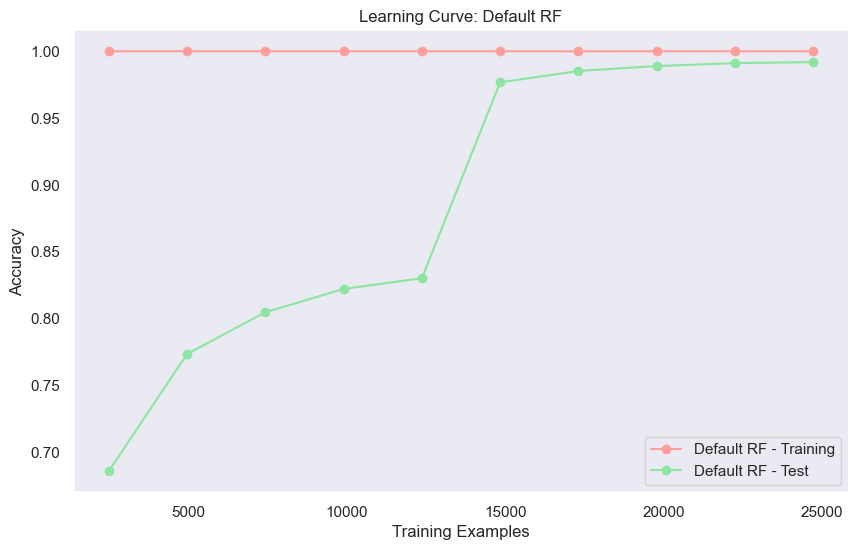

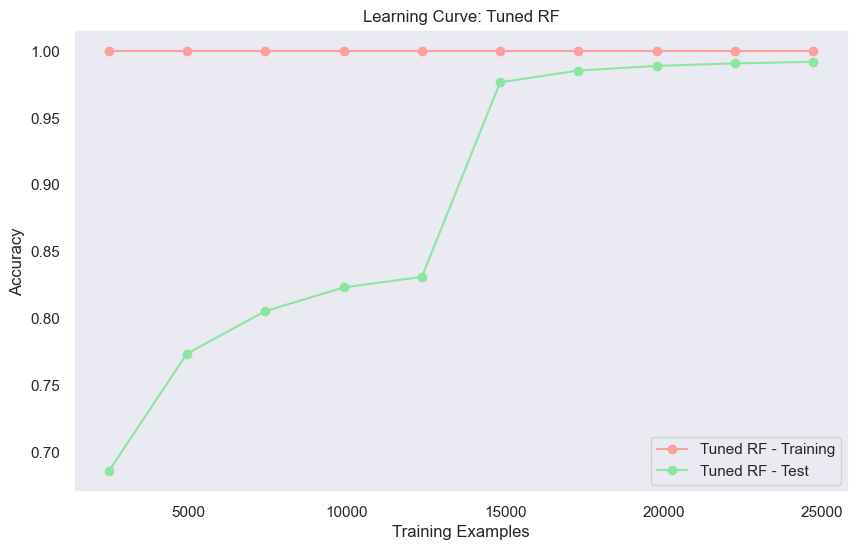

In [173]:
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curve(estimator, X_train, y_train, label):
    plt.figure(figsize=(10, 6))
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label=f"{label} - Training")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label=f"{label} - Test")
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    plt.title(f"Learning Curve: {label}")
    plt.legend(loc="best")
    plt.grid()

# Plot learning curve for default model
plot_learning_curve(default_rf, X_resampled, y_resampled, "Default RF")

# Plot learning curve for tuned model
plot_learning_curve(best_model, X_resampled, y_resampled, "Tuned RF")

plt.show()


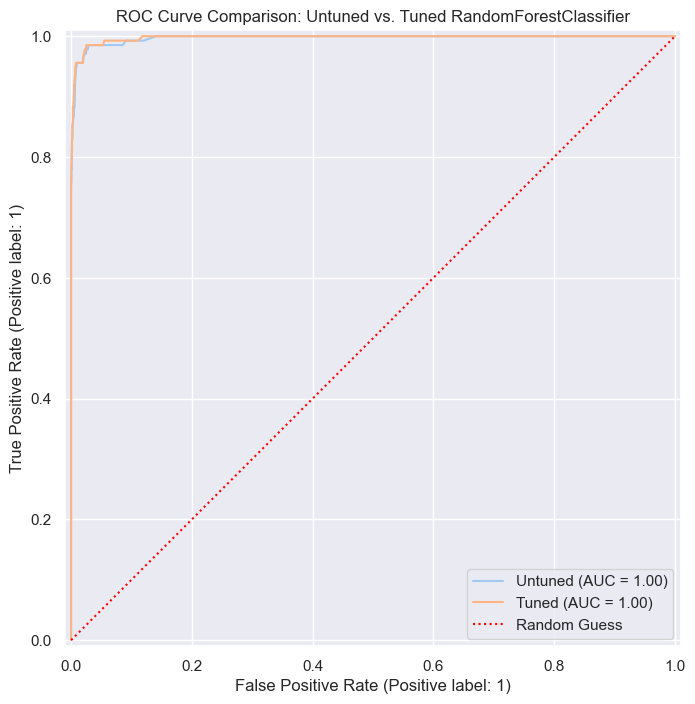

In [185]:
# Plot ROC curves for untuned and tuned models
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# ROC curve for the untuned model
RocCurveDisplay.from_estimator(default_rf, X_test_scaled, y_test, ax=ax, name="Untuned")

# ROC curve for the tuned model
RocCurveDisplay.from_estimator(best_model, X_test_scaled, y_test, ax=ax, name="Tuned")

# 50% random line (diagonal line for random guess)
x = np.linspace(0, 1, 2)
ax.plot(x, x, ":", color="red", label="Random Guess")

# Set the title and legend
ax.set_title("ROC Curve Comparison: Untuned vs. Tuned RandomForestClassifier")
ax.legend(loc="lower right")

# Display the plot
plt.show()

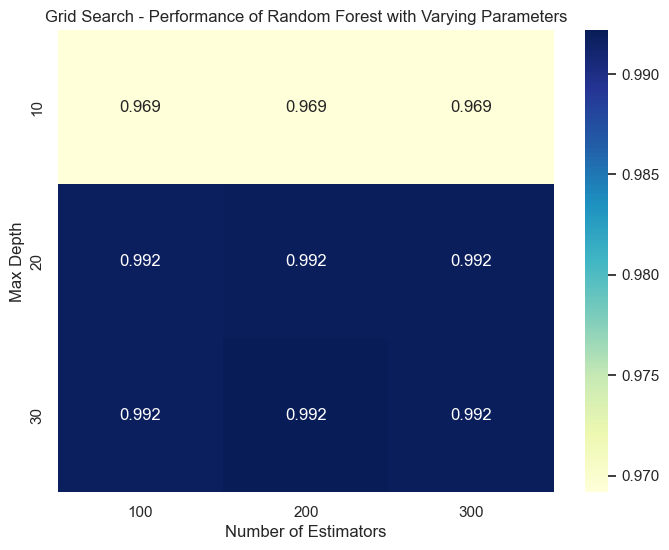

In [181]:
import seaborn as sns

# Get the grid search results as a DataFrame
grid_results = pd.DataFrame(grid_search.cv_results_)

# Plot the relationship between n_estimators and mean_test_score
plt.figure(figsize=(8, 6))
sns.heatmap(grid_results.pivot_table(index='param_rf__max_depth', columns='param_rf__n_estimators', values='mean_test_score'),
            cmap="YlGnBu", annot=True, fmt=".3f")
plt.title("Grid Search - Performance of Random Forest with Varying Parameters")
plt.xlabel("Number of Estimators")
plt.ylabel("Max Depth")
plt.show()


The second tuned model is similar to results from the first tuned model, but this tuned model did improve slightly

In summary, while both models perform excellently, the tuned model shows a slight improvement, especially in terms of recall for the minority class, and this could make it preferable for certain applications where detecting the minority class

* Untuned Model: The untuned model shows a precision of 0.85 and recall of 0.88 for class 1, which suggests it is fairly good at identifying positive samples, but it’s slightly conservative (has some false positives).
  
* Tuned Model: The tuned model improves this by increasing recall to 0.92, meaning it is better at identifying all actual positives (reducing false negatives), but it sacrifices a small amount of precision (from 0.85 to 0.86). This trade-off shows that the tuning process likely prioritized recall for the minority class, which is often important when dealing with imbalanced datasets.

REFERENCES:
* https://www.analyticsvidhya.com/blog/2020/01/build-your-first-machine-learning-pipeline-using-scikit-learn/
* https://medium.com/geekculture/classification-in-machine-learning-a-guide-for-beginners-fe586e299721